In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from scipy import sparse
from random import randint
from collections import defaultdict

import collections
import math
import random
import numpy as np
import tensorflow as tf
import scipy as sc

random.seed(1337)
np.random.seed(322)
tf.set_random_seed(50547)

# LSA
Для выполнения первого задания воспользуемся библиотечными функциями.

Для парсинга википедии я использовал фукнции библиотеки gensim.

Вариантов препроцессинга было несколько - можно было выкидывать из итогового текстового файла т.н. стоп-слова, которые не несут особого смысла, и выкидывание их из контекстов только улучшает качество этих самых контестов, но я поступил по-другому и просто выкинул слишком редкие (встречаются менее чем в 10 статьях) и слишком частые (встречаются более чем в 1/5 статей) слова. Может показаться, что граница слишком частых достаточно слишком высока, но мне не пришли в голову какие-то слова, смысл которых нас интересуют, которые могут встречаться так часто (ну, я немого сожалел о выкидывании слова new, но совсем немного)

Выкинув редкие же слова мы избавились от откровенного мусора, типа транскрипций слов на их оригинальном языке, но и, возможно, повыкидывали какие-то интересные нам специфичные слова, типа CEO компаний

Т.к. просто хочется посмотреть на обработанный таким образом текст и при перезапуске ядра не запускать достаточно длительную обработку снова, сохраняем полученный результат в файл

In [ ]:
from gensim.corpora import WikiCorpus
import logging
import nltk
from nltk.corpus import stopwords

def parse_wiki(wiki_bz_file):
    output = open('./wiki_text_dump.txt', 'w')
    wiki = WikiCorpus(wiki_bz_file, lemmatize=False)
    wiki.dictionary.filter_extremes(10, 0.2, 60000)
    voc = set(wiki.dictionary.values())
    for text in wiki.get_texts():
        text = [w for w in text if w in voc]
        output.write(" ".join(text) + "\n")
    output.close()
    return

parse_wiki("./simplewiki-20170201-pages-articles.xml.bz2")

Пользуемся библиотечными функциями для построения модели мешка слов с использованием метрики tf-idf, заодно бесплатно получаем словари (индекс-слово и слово-индекс). Я выбрал tf-idf метрку, т.к. мне кажется, что из предложенных в ней содержится максимум информации и расстояния между различными документами и словами интепретируются четче

In [4]:
dump = open('wiki_text_dump.txt', 'r')
tfidf_maker = TfidfVectorizer(use_idf=True)
tfidf_matrix = tfidf_maker.fit_transform(dump)
dump.close()

In [5]:
vocabulary_size = tfidf_matrix.shape[1]
direct_dict = tfidf_maker.vocabulary_
inverted_dict= dict(zip(tfidf_maker.vocabulary_.values(), tfidf_maker.vocabulary_.keys()))

У нас остается 49263 слов.

Транспонируем матрицу чтобы получить в качестве первого аргумента компактные представления слов, а не документов

In [16]:
LSA_DIMS = 128

In [6]:
tfidf_matrix = tfidf_matrix.transpose()
svd_maker = TruncatedSVD(LSA_DIMS)
lsa_embedding = svd_maker.fit_transform(tfidf_matrix)

In [ ]:
np.save('lsa', lsa_embedding)

Сохраняем результат, чтобы не пересчитывать в дальнейшем

In [40]:
lsa_embedding = np.load('lsa.npy')

Для поиска ближайшего соседа воспользуемся функцией scipy.spatial.distance.cdist(X, Y, metric), вычисляющей расстояния между парами строк матриц X и Y (у нас Y это один вектор)

При поиске аналогии авторы всех статей выкидывают из выдачи слова из запроса, у меня же задачи что-то предсказать нет, а лишь посмотреть, как работают модели, поэтому я этого делать не буду 

In [165]:
def find_k_nearest(word, embedding_matrix, k, metric):
    distances = sc.spatial.distance.cdist(embedding_matrix, 
                                embedding_matrix[direct_dict[word]].reshape(1, embedding_matrix.shape[1]),
                                metric)
    distances = distances.flatten()
    order = np.argsort(distances)
    for index in order[:k]:
        print("%15s, %f" % (inverted_dict[index], distances[index]))

In [166]:
def analogy_k_nearest(word1, word2, word3, embedding_matrix, k, metric):
    word1_vector = embedding_matrix[direct_dict[word1]]
    word2_vector = embedding_matrix[direct_dict[word2]]
    word3_vector = embedding_matrix[direct_dict[word3]]
    new_word_vector = word1_vector - word2_vector + word3_vector
    distances = sc.spatial.distance.cdist(embedding_matrix, 
                                new_word_vector.reshape(1, embedding_matrix.shape[1]),
                                metric)
    distances = distances.flatten()
    order = np.argsort(distances)
    for index in order[:k]:
        print("%15s, %f" %(inverted_dict[index], distances[index]))

In [138]:
def metrics_comparison(word, embedding_matrix, k):
    cos_distances = sc.spatial.distance.cdist(embedding_matrix, 
                                embedding_matrix[direct_dict[word]].reshape(1, embedding_matrix.shape[1]),
                                'cosine')
    cos_distances = cos_distances.flatten()
    cos_order = np.argsort(cos_distances)
    
    euc_distances = sc.spatial.distance.cdist(embedding_matrix, 
                                embedding_matrix[direct_dict[word]].reshape(1, embedding_matrix.shape[1]),
                                'euclidean')
    euc_distances = euc_distances.flatten()
    euc_order = np.argsort(euc_distances)
    
    man_distances = sc.spatial.distance.cdist(embedding_matrix, 
                                embedding_matrix[direct_dict[word]].reshape(1, embedding_matrix.shape[1]),
                                'cityblock')
    man_distances = man_distances.flatten()
    man_order = np.argsort(man_distances)
    print("|    cosine    |   euclidean  |   manhattan  |")
    for index in range(k):
        print("|%14s|%14s|%14s|" % (inverted_dict[cos_order[index]],
                                   inverted_dict[euc_order[index]],
                                   inverted_dict[man_order[index]]))

Попробуем косинусную и евклидову метрики:

В качестве еще одной меры, которую стоит попробовать, можно использовать Манхеттенское растояние

In [139]:
metrics_comparison('moscow', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|        moscow|        moscow|        moscow|
|          sfsr|        russia|        russia|
|         rsfsr|       ukraine|    petersburg|
|  mikhailovich|    petersburg|       ukraine|
|        russia|          ussr|          ussr|
|          ussr|      vladimir|      vladimir|
|       russian|     ukrainian|     ukrainian|
|        alexey|        oblast|        oblast|
|      orenburg|        stalin|        stalin|
|     leningrad|       belarus|       belarus|


Здесь, например, евклидово и городское расстояния мне показались точнее косинусного.

Попробуем несколько фруктов:

In [140]:
metrics_comparison('lemon', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|         lemon|         lemon|         lemon|
|        flavor|        flavor|        flavor|
|         plums|          ripe|       flavour|
|       flavour|       flavour|          ripe|
|      cinnamon|          lime|          lime|
|         eaten|        citrus|        citrus|
|          ripe|       cabbage|       cabbage|
|       almonds|       dessert|         salad|
|          lime|         salad|        tomato|
|        creamy|         olive|       dessert|


In [141]:
metrics_comparison('apple', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|         apple|         apple|         apple|
|        laptop|           mac|           mac|
|           mac|            os|            os|
|     macintosh|      hardware|      hardware|
|          ipod|        server|     processor|
|       macbook|       desktop|       desktop|
|   smartphones|   application|   application|
|      packages|     processor|        server|
|    smartphone|  applications|     interface|
|       laptops|     interface|  applications|


Месяца:

In [142]:
metrics_comparison('september', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|     september|     september|     september|
|        august|       october|       october|
|       october|        august|        august|
|        dupree|       release|      premiere|
|      cosgrove|      premiere|         dates|
|     zookeeper|        attack|      speaking|
|    pellegrini|         dates|       release|
| astrophysical|          last|      animated|
|    inevitably|            jr|         jones|
|          rapp|     biography|          date|


Имена:

In [143]:
metrics_comparison('john', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|          john|          john|          john|
|        robert|       william|         james|
|        thomas|         james|       william|
|         james|        robert|        robert|
|       richard|        george|        george|
|        linder|          paul|          paul|
|         peter|       richard|       richard|
|       william|        thomas|        thomas|
|          paul|         david|         david|
|        melvyn|         henry|       michael|


In [144]:
metrics_comparison('nikolay', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       nikolay|       nikolay|       nikolay|
|     aleksandr|     aleksandr|     aleksandr|
|       aleksei|        sergey|        dmitry|
|        andrei|        dmitry|        sergey|
|        sergey|        vasily|        andrey|
|        viktor|        andrey|        vasily|
|        andrey|           lev|        valeri|
|       mikhail|        georgy|       aleksei|
|    konstantin|       anatoly|        georgy|
|        sergei|        valeri|       anatoly|


Цвета:

In [145]:
metrics_comparison('yellow', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|        yellow|        yellow|        yellow|
|          pale|        colors|        colors|
|       colored|        orange|        orange|
|       reddish|        colour|        colour|
|        bluish|          dark|          pink|
|     yellowish|          pink|          gray|
|       pinkish|          gray|          dark|
|         green|        bright|        bright|
|          blue|        purple|        purple|
|     harlequin|       colours|       colours|


Репперская тусовка:

In [146]:
metrics_comparison('tupac', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|         tupac|         tupac|         tupac|
|           def|        hopsin|         fella|
|         fella|         fella|        hopsin|
|        shakur|         busta|      babyface|
|         snoop|      babyface|         busta|
|        rapper|         doggy|          suge|
|        hopsin|collaborations|         doggy|
|           tha|       outkast|        flatts|
|           dre|          eazy|collaborations|
|          suge|       trainor|        rascal|


Популярные поисковые запросы:

In [147]:
metrics_comparison('anime', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|         anime|         anime|         anime|
|         manga|         manga|         manga|
|        gundam|        voiced|        voiced|
|         kanon|         robot|    adventures|
|        naruto|    adventures|         robot|
|        tezuka|      monsters|      monsters|
|        shonen|       monster|       samurai|
|    serialized|       vampire|        dragon|
|           viz|         buffy|       vampire|
|       ketchum|       samurai|       cartoon|


Черепашки-ниндзя:

In [148]:
metrics_comparison('raphael', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       raphael|       raphael|       raphael|
|         pieta|     rembrandt|    caravaggio|
|  michelangelo|    caravaggio|     rembrandt|
|    caravaggio|        fresco|        vasari|
|      leonardo|        vasari|        titian|
|        fresco|      frescoes|      angelico|
|     rembrandt|        giotto|    botticelli|
|      ghiberti|        titian|      frescoes|
|        titian|    botticelli|        giotto|
|         vinci|      angelico|        fresco|


Автомобильные марки:

In [149]:
metrics_comparison('toyota', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|        toyota|        toyota|        toyota|
|       bugatti|         honda|         honda|
|            gt|     chevrolet|     chevrolet|
|     sportscar|           bmw|           bmw|
|         honda|       chassis|       chassis|
|     chevrolet|         truck|           fia|
|           car|       fastest|        sauber|
|       porsche|          benz|           lap|
|         motor|           fia|           suv|
|        camaro|           lap|          benz|


Небесные тела:

In [150]:
metrics_comparison('jupiter', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       jupiter|       jupiter|       jupiter|
|   inclination|          moon|          moon|
|     spherical|        saturn|        saturn|
|  eccentricity|   inclination|   inclination|
|      ecliptic|         moons|         moons|
|    retrograde|       orbital|     spherical|
|        ananke|     spherical|       orbital|
|      sheppard|        orbits|        orbits|
|  inclinations|      diameter|      diameter|
|          nses|  eccentricity|  eccentricity|


In [151]:
metrics_comparison('frog', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|          frog|          frog|          frog|
|         frogs|         frogs|         frogs|
|      tadpoles|          toad|          toad|
|     spadefoot|       habitat|       habitat|
|       ranidae|    threatened|         toads|
|       hylidae|         toads|    threatened|
|         toads|          iucn|          iucn|
|    caecilians|        larvae|     subfamily|
|          bufo|      habitats|        larvae|
|         anura|    subspecies|       beetles|


In [152]:
metrics_comparison('detective', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|     detective|     detective|     detective|
|      starring|       mystery|       mystery|
|          cast|           spy|           spy|
|       mystery|        parker|        whedon|
|           spy|        filmed|       vampire|
|        vaughn|       vampire|        laurie|
|        parker|       filming|     superhero|
|         sheen|     halloween|         ethan|
|        comedy|          jake|        filmed|
|           cop|       villain|        carrie|


In [189]:
metrics_comparison('tolstoy', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       tolstoy|       tolstoy|       tolstoy|
|        fyodor|        fyodor|      turgenev|
|        andrei|      turgenev|        fyodor|
|      turgenev|     pasternak|   dostoyevsky|
|           lev|   dostoyevsky|     pasternak|
|       mikhail|       grigori|   nikolaevich|
|       nikolai|       godunov|       tsarina|
|     aleksandr|   nikolaevich|       grigori|
|         boris|      lyudmila|       godunov|
|        vasily|       aleksei|         gogol|


In [201]:
metrics_comparison('gold', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|          gold|          gold|          gold|
|        silver|        silver|        silver|
|        bronze|        bronze|        bronze|
|         medal|        medals|        medals|
|        moguls| championships| championships|
|      medalist|    volleyball|       skating|
|          iaaf|       skating|    volleyball|
|        skated|       awarded|           win|
|       skating|           win|       awarded|
|   sportswoman|         honor|        figure|


In [218]:
metrics_comparison('li', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|            li|            li|            li|
|       chinese|          qing|          tang|
|         zhang|          tang|          qing|
|          chen|           liu|           liu|
|         china|          ming|          yuan|
|           wen|          yuan|         zhang|
|          tang|         zhang|          ming|
|         huang|            yi|            yi|
|        manchu|         chang|          chen|
|          qing|        pinyin|        pinyin|


In [226]:
metrics_comparison('soldier', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       soldier|       soldier|       soldier|
|         rebel|       capture|       colonel|
|       admiral|       colonel|       wounded|
|      wounding|       admiral|      sergeant|
|       capture|       wounded|       capture|
|       marshal|         siege|       admiral|
|       colonel|       marshal|     battalion|
|      withdraw|       victory|        combat|
|     surrender|      captured|       marines|
|       wounded| revolutionary|         siege|


In [227]:
metrics_comparison('chocolate', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|     chocolate|     chocolate|     chocolate|
|         cream|          cake|          cake|
|       flavors|         cream|        butter|
|        butter|        butter|   ingredients|
|      desserts|   ingredients|         cream|
|         baked|        cooked|         juice|
|       dessert|         fried|        drinks|
|         juice|         taste|        cooked|
|        recipe|         juice|         beans|
|         cakes|         beans|         fried|


In [234]:
metrics_comparison('guitar', lsa_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|        guitar|        guitar|        guitar|
|         drums|        vocals|        vocals|
|          bass|          bass|          bass|
|       guitars|         drums|         drums|
|        vocals|       backing|       backing|
|       backing|          lead|          lead|
|    percussion|       members|     keyboards|
|     keyboards|     keyboards|       guitars|
|    turntables|       present|        rhythm|
|     saxophone|       guitars|    percussion|


На лягушках(да и в большинстве проверенных мною примеров) мне больше нравится косинусная мера, выдавшая различные виды лягушек, а не общие слова, которые можно встретить в статье про лягушек.

Подробнее метрики и варианты представления сравним позже

Городское расстояние - достаточно качественная метрика, в какой-то ситуации она может и покажет себя, но авторами рассматриваемых моделей она не используется

# Word2vec

Для начала представим наш дамп в виде листа индексов слов

In [7]:
dump = open('wiki_text_dump.txt', 'r')
data = []
for string in dump:
    for word in string.split():
        if word in direct_dict.keys():
            data.append(direct_dict[word])
dump.close()

Длина нашего текста

In [167]:
len(data)

13342413

In [6]:
batch_size = 800
embedding_size = 200
skip_window = 4
num_skips = 8
num_sampled = 64
w2v_graph = tf.Graph()
data_index = 0

В качестве размерности векторного представления возьмем 200 (из рекомендуемого в статье промежутка 200-300, у нас же не так много слов); 64 негативных примеров для каждой пары слов, как рекомендуется в статье; размер окна 4, размер батча 800 и количество использований одного слова 8, чтобы в батч попадали как раз всевозможные пары слово-контекст

Реализация с помощью негатив сэмплинга подсмотрена на просторах [гитхаба](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

Количество слов в data 13342413, выбранное количество шагов 1000000, за один батч мы обрабатываем $800 / 8 = 100$ слов, получается мы делаем ~7.5 проходов по тексту (эпох)

В обозначениях:

$T$ - размер корпуса

$W$ - размер словаря

$c$ - радиус окна

$d$ - размерность представлений

$k$ - количество отрицательных примеров

$num\_steps$ - число шагов

$batch\_size$ - размер батча

Сложность при использования негатив сэмплинга $O(k  \times d  \times batch\_size  \times num\_steps)$

Где в моем случае $num\_steps = \frac{T  \times epoches  \times (2  \times c)} {batch\_size}$

Первые два множителя $k$ и $d$ отвечают за количество обновляемых за один шаг параметров матрицы, третий и четвертый - за количество этих самых шагов. В вопросе использования разных апроксимаций активации нас интересует именно первые два множителя, т.к. в наивной реализации они в итоге дают размер матрицы $W \times d$, что очень затратно

In [90]:
def get_batch(batch_size, num_skips, skip_window):
    global data_index
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [101]:
with w2v_graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    loss = tf.reduce_mean( tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    init = tf.global_variables_initializer()

In [102]:
num_steps = 1000000
data_index = 0
with tf.Session(graph=w2v_graph) as session:
    init.run()
    for step in range(num_steps):
        batch_inputs, batch_labels = get_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    w2v_embedding = embeddings.eval()

In [103]:
np.save('w2v', w2v_embedding)

In [163]:
w2v_embedding = np.load('w2v.npy')

Проверяем на наших словах:

In [235]:
metrics_comparison('moscow', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|        moscow|        moscow|        moscow|
|       russian|       russian|       russian|
|    petersburg|        russia|        russia|
|        russia|    petersburg|    petersburg|
|        soviet|          time|       history|
|      vladimir|    remembered|          time|
|     ukrainian|        famous|           now|
|    remembered|           now|      although|
|       ukraine|          gone|          once|
|     alexander|      although|       another|


In [236]:
metrics_comparison('lemon', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|         lemon|         lemon|         lemon|
|         juice|         clear|         clear|
|        flavor|         sweet|        appear|
|          sour|        others|        others|
|         sweet|      prepared|        author|
|         clear|         noted|          told|
|        cherry|          well|        rarely|
|          pulp|          told|         quick|
|         fruit|       however|         quite|
|         drink|        though|         sweet|


In [237]:
metrics_comparison('apple', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|         apple|         apple|         apple|
|           inc|           inc|           inc|
|       beatles|        others|           out|
|     computers|       another|         whose|
|        leaves|          them|        others|
|         touch|      recently|           eat|
|         store|         might|      recently|
|           eat|           out|       however|
|          lets|          just|     computers|
|        iphone|         close|          them|


In [238]:
metrics_comparison('september', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|     september|     september|     september|
|        august|        august|       october|
|       october|       october|        august|
|          july|          july|          july|
|          june|          june|          june|
|      november|      november|      november|
|         march|         march|         march|
|      february|      february|      february|
|      december|      december|      december|
|         april|         april|         later|


In [239]:
metrics_comparison('john', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|          john|          john|          john|
|         james|         james|         james|
|       william|         peter|       william|
|         peter|       william|         peter|
|        george|        author|        thomas|
|          paul|       richard|        robert|
|       richard|        george|          both|
|        robert|        thomas|       michael|
|        author|        robert|        george|
|       michael|       michael|       january|


In [240]:
metrics_comparison('nikolay', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       nikolay|       nikolay|       nikolay|
|       mikhail|       russian|        social|
|       russian|          ivan|       russian|
|          ivan|       mikhail|          ivan|
|         boris|         still|       mikhail|
|      vladimir|        social|       outside|
|        social|       reasons|    especially|
|    petersburg|      although|         blair|
|        dmitry|         boris|         today|
|        russia|          idea|         still|


In [241]:
metrics_comparison('yellow', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|        yellow|        yellow|        yellow|
|          blue|          blue|         black|
|         white|         white|         white|
|        orange|        colour|          blue|
|        colour|         black|        colour|
|         black|        orange|        orange|
|           red|         along|          both|
|        bright|        bright|         along|
|         green|           red|          side|
|          pale|          dark|           red|


In [242]:
metrics_comparison('tupac', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|         tupac|         tupac|         tupac|
|       hossain|          love|          love|
|     crossbody|         thing|         young|
|         jimmu|            my|         thing|
|     stromberg|          baby|            so|
|       gumball|            no|          rich|
|       nihongi|         young|       limited|
|       inserts|       limited|          land|
|          ripa|      business|         happy|
|        althea|       tribute|      campbell|


In [243]:
metrics_comparison('anime', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|         anime|         anime|         anime|
|         manga|         manga|         manga|
|     character|     character|     character|
|        comics|    characters|    characters|
|        series|        series|        series|
|    characters|        appear|        appear|
|         comic|         theme|         theme|
|         theme|      appeared|         short|
|        movies|        movies|          game|
|      episodes|      episodes|        comics|


In [244]:
metrics_comparison('raphael', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       raphael|       raphael|       raphael|
|     decorated|        famous|      probably|
|       artists|      probably|         works|
|       painted|       painted|          work|
|       chapter|     mentioned|      inspired|
|       painter|        latter|       chapter|
|       madonna|         works|        famous|
|        giotto|       artists|     architect|
|        gothic|       chapter|     described|
|  michelangelo|       purpose|           own|


In [245]:
metrics_comparison('toyota', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|        toyota|        toyota|        toyota|
|         honda|          cars|          cars|
|            tf|         drive|          seat|
|          cars|           car|        racing|
|        racing|     purchased|         drive|
|         sized|        racing|     expensive|
|         drive|         sized|      recently|
|     purchased|      recently|  headquarters|
|        nakano|       offered|           car|
|      chrysler|          seat|           due|


In [246]:
metrics_comparison('jupiter', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       jupiter|       jupiter|       jupiter|
|         moons|          moon|          moon|
|          moon|      distance|        planet|
|         venus|        planet|         earth|
|      diameter|    discovered|      distance|
|       neptune|    identified|    identified|
|         orbit|      diameter|    discovered|
|        planet|characteristics|          only|
|      distance|          same|          same|
|       planets|         taken|      diameter|


In [247]:
metrics_comparison('frog', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|          frog|          frog|          frog|
|         frogs|          rare|         small|
|          rush|          rush|         brown|
|        turtle|          case|   competition|
|          rare|         clear|          rare|
|    endangered|   competition|         clear|
|          soft|          both|          rush|
|   competition|        though|        though|
|        mammal|        caught|          soft|
|       species|          soft|    particular|


In [248]:
metrics_comparison('detective', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|     detective|     detective|     detective|
|       starred|       starred|           man|
|      starring|     character|       starred|
|         roles|        friend|     character|
|     character|           man|         being|
|        holmes|         roles|    characters|
|         doyle|      appeared|      starring|
|         mafia|       himself|     situation|
|            mr|       friends|        warren|
|        police|           met|         roles|


In [249]:
metrics_comparison('tolstoy', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       tolstoy|       tolstoy|       tolstoy|
|           ewa|          rose|         house|
|       warlock|         novel|          tsar|
|         snuff|         books|      suddenly|
|    ballantine|      inventor|      children|
|         waged|          poor|       husband|
|    flashdance|     alexander|          poor|
|       olmsted|     physician|           leo|
|        crenna|         young|     alexandra|
|        allard|        autumn|          rose|


In [250]:
metrics_comparison('gold', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|          gold|          gold|          gold|
|        silver|        silver|        silver|
|       diamond|       diamond|       diamond|
|      platinum|         along|           off|
|         medal|           off|         along|
|     australia|          both|          only|
|         along|     australia|          both|
|        bronze|          well|           him|
|           off|          been|        around|
|          rush|          side|     australia|


In [251]:
metrics_comparison('li', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|            li|            li|            li|
|          chen|        births|         china|
|            yu|         china|        births|
|            wu|       chinese|     alongside|
|       beijing|     meanwhile|     meanwhile|
|       chinese|      actually|       chinese|
|            mo|          both|          same|
|         china|          same|       instead|
|           liu|      together|        future|
|         zhang|        others|      actually|


In [252]:
metrics_comparison('soldier', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|       soldier|       soldier|       soldier|
|          army|      soldiers|      soldiers|
|      soldiers|          army|           may|
|       officer|          work|       another|
|    politician|     scientist|     scientist|
|     scientist|           may|       officer|
|      diplomat|       officer|          work|
|       october|           met|       however|
|      december|          said|       usually|
|        writer|       another|          army|


In [253]:
metrics_comparison('chocolate', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|     chocolate|     chocolate|     chocolate|
|        butter|         sweet|         sweet|
|         cream|           own|           own|
|         sweet|         added|      prepared|
|         sugar|        always|       putting|
|        peanut|      prepared|        always|
|         foods|         ready|         while|
|        powder|      intended|        filled|
|        cheese|        filled|         ready|
|         drink|       putting|          safe|


In [254]:
metrics_comparison('guitar', w2v_embedding, 10)

|    cosine    |   euclidean  |   manhattan  |
|        guitar|        guitar|        guitar|
|          bass|         drums|          bass|
|         drums|          bass|         drums|
|        vocals|        vocals|        vocals|
|     guitarist|     guitarist|     guitarist|
|        rhythm|          lead|          lead|
|     keyboards|        rhythm|        rhythm|
|          lead|       drummer|       drummer|
|       backing|          band|          band|
|       guitars|    songwriter|      musician|


Опять в целом косинусная мера мне понравилась больше

С тестом модель справилась:

In [186]:
analogy_k_nearest('king', 'man', 'woman', w2v_embedding, 10, 'cosine')

           king, 0.170627
          queen, 0.350981
          woman, 0.403082
       daughter, 0.416596
        kingdom, 0.424317
            son, 0.425211
           wife, 0.425336
        husband, 0.425462
         prince, 0.446796
         father, 0.447565


Для страны определяют столицу
Для компании определяют CEO
Для прилагательного определяют превосходную форму
Для слова определяют множественное число
Для слова находит его антоним

Определить страницу страны можно с помощью нашей православной аналогии:

In [258]:
analogy_k_nearest('moscow', 'russia', 'france', w2v_embedding, 10, 'cosine')

         france, 0.325203
         moscow, 0.335982
          paris, 0.399836
         french, 0.449188
          louis, 0.493501
           june, 0.507098
        belgium, 0.513387
           july, 0.513753
             de, 0.520945
          italy, 0.526140


Из-за выкидывания редких слов, такой информации, как СЕО, у нас почти не осталось, но аналогия примерно следующая:

In [286]:
analogy_k_nearest('zuckerberg', 'facebook', 'zara', w2v_embedding, 10, 'cosine')

     zuckerberg, 0.271240
           zara, 0.301852
          porno, 0.624739
          yaqub, 0.632030
         guilin, 0.647981
          lorre, 0.648642
           mily, 0.650874
           cudi, 0.651485
      phillippe, 0.653630
          sissy, 0.654281


Определяем превосходную форму прилагательного:

In [288]:
analogy_k_nearest('worst', 'bad', 'good', w2v_embedding, 10, 'cosine')

          worst, 0.145146
           best, 0.421322
           ever, 0.455149
     supporting, 0.460590
        leading, 0.464686
           good, 0.481028
    performance, 0.482622
         behind, 0.495227
           hard, 0.502438
           well, 0.505560


Множественное число:

In [289]:
analogy_k_nearest('men', 'man', 'woman', w2v_embedding, 10, 'cosine')

            men, 0.176064
          women, 0.230899
          woman, 0.273669
          girls, 0.405224
       children, 0.414990
            she, 0.437842
           full, 0.440135
        allowed, 0.445752
         should, 0.450255
           only, 0.456604


Антоним:

In [290]:
analogy_k_nearest('good', 'bad', 'black', w2v_embedding, 10, 'cosine')

          black, 0.174119
          white, 0.295793
            red, 0.424453
          brown, 0.446722
           full, 0.452165
          green, 0.465409
           dark, 0.478901
           hole, 0.479870
           good, 0.480154
           blue, 0.482615


# GLOVE

Используем размерность векторного представления и ширину окна такие же, что и в word2vec. Счетчик совместных вхождений, матрица X, у нас будет с долями - чем дальше находятся слова, тем меньше увеличивается счетчик - на $^1/_{ dist}$, структура графа подсмотрена на [гитхабе](https://github.com/GradySimon/tensorflow-glove/blob/master/tf_glove.py)

Сложность модели оценить сложно - понятно, что она линейная от числа ненулевых элементов матрицы X, линейная от размерности векторов-представлений (т.к. за шаг мы обновляем по одному представлению в каждой из двух матриц - представлений центрального слова и представлений контекстов), но зависимость число ненулевых элементов от ширины окна слабее, чем линейная.

По ощущениям обучается быстрее, чем w2v

In [14]:
cont_width = 4
embedding_size = 200

In [15]:
X = sparse.lil_matrix((vocabulary_size, vocabulary_size), dtype=np.float64)
for i in range(len(data)):
    for j in range(max(0, i - cont_width), i):
        X[data[i], data[j]] += 1.0 / (i - j)
    for j in range(min((i + 1), len(data)), min((i + 1 + cont_width), len(data))):
        X[data[i], data[j]] += 1.0 / (j - i)
X = sparse.coo_matrix(X)

In [16]:
glove_learning_rate = 0.05
batch_size = 100

В качестве $\\f(X_{ij})$ возьмем используемую в подсмотренной реализации и подходящую по критериям авторов статьи функцию $min_{} (1, {({X_{ij}}/{X_{max}})}^{0.75})$, где $X_{max}$ - не именно максимальное значачение в матрице $X_{ij}$, а какая-то разумная константа, у меня равная 400

От функции авторы статьи требуют в том числе равенство нулю в нуле - именно поэтому нам не нужно рассматривать нулевые матричные элементы, потому что если бы это делали, сложность обучения многократно возросла бы, т.к. теряется основная фишка этой модели - тренироваться только на совместных вхождениях пар слов, а не по всевозможным парам слов. Тестировать такую модель - все равно, что не приближать софтмакс в w2v.

In [19]:
glove_graph = tf.Graph()
with glove_graph.as_default():

    focal_input = tf.placeholder(tf.int32, shape=[batch_size],
                                        name="focal_words")
    context_input = tf.placeholder(tf.int32, shape=[batch_size],
                                          name="context_words")
    cooccurrence_count = tf.placeholder(tf.float32, shape=[batch_size],
                                               name="cooccurrence_count")

    focal_embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], 1.0, -1.0) / float(embedding_size + 1))
    context_embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], 1.0, -1.0) / float(embedding_size + 1))

    focal_biases = tf.Variable(
        tf.random_uniform([vocabulary_size], 1.0, -1.0) / float(embedding_size + 1)
    )
    context_biases = tf.Variable(
        tf.random_uniform([vocabulary_size], 1.0, -1.0) / float(embedding_size + 1)
    )

    focal_embedding = tf.nn.embedding_lookup([focal_embeddings], focal_input)
    context_embedding = tf.nn.embedding_lookup([context_embeddings], context_input)
    focal_bias = tf.nn.embedding_lookup([focal_biases], focal_input)
    context_bias = tf.nn.embedding_lookup([context_biases], context_input)

    f = tf.minimum(1.0, tf.pow(tf.div(cooccurrence_count, 400),0.75))

    embedding_product = tf.reduce_sum(tf.multiply(focal_embedding, context_embedding), 1)

    log_cooccurrences = tf.log(tf.to_float(cooccurrence_count))

    distance_expr = tf.square(tf.add_n([
        embedding_product,
        focal_bias,
        context_bias,
        tf.negative(log_cooccurrences)]))

    single_losses = tf.multiply(f, distance_expr)
    total_loss = tf.reduce_sum(single_losses)
    optimizer = tf.train.AdagradOptimizer(glove_learning_rate).minimize(total_loss)

    combined_embeddings = tf.add(focal_embeddings, context_embeddings,
                                        name="combined_embeddings")

Обучение происходит намного быстрее, чем word2vec'а, поэтому можем себе позволить пару лишних эпох

In [20]:
num_epochs = 12

In [21]:
with tf.Session(graph=glove_graph) as session:
    tf.global_variables_initializer()
    for epoch in range(num_epochs):
        step = 0
        i_s = []
        j_s = []
        counts = []
        for (i, j, X_ij) in zip(X.row, X.col, X.data):
            if len(j_s) == batch_size:
                feed_dict = {focal_input: i_s, context_input: j_s, 
                             cooccurrence_count: counts}
                session.run([optimizer], feed_dict=feed_dict)
                del i_s[:], j_s[:], counts[:]
            else:
                i_s.append(i)
                j_s.append(j)
                counts.append(X_ij)
            step += 1
    glove_embedding = combined_embeddings.eval()

Сохраняем веса

In [27]:
np.save('glove', glove_embedding)

In [8]:
glove_embedding = np.load('glove.npy')

Тест модель проходит:

In [187]:
analogy_k_nearest('king', 'man', 'woman', glove_embedding, 10, 'cosine')

           king, 0.191422
          vania, 0.331690
          queen, 0.335856
         mercia, 0.383342
        consort, 0.388591
        crowned, 0.408801
          argos, 0.409981
         shaman, 0.418886
         dedede, 0.420443
         wessex, 0.420841


# Сравнение моделей

Перепишем функцию поиска ближайшего слова так, чтобы она не выводила результат, а просто возвращала его.

In [12]:
def find_k_nearest(word1, word2, word3, embedding_matrix, k, metric):
    word1_vector = embedding_matrix[direct_dict[word1]]
    word2_vector = embedding_matrix[direct_dict[word2]]
    word3_vector = embedding_matrix[direct_dict[word3]]
    new_word_vector = word1_vector - word2_vector + word3_vector
    distances = sc.spatial.distance.cdist(embedding_matrix, 
                                new_word_vector.reshape(1, embedding_matrix.shape[1]),
                                metric)
    distances = distances.flatten()
    order = np.argsort(distances)
    nearest = [inverted_dict[i] for i in order[:k]]
    return nearest

Авторы оригинальный статьи о w2v составили большой пак вопросов на поиск аналогий, мы случайным образом возьмем 1/10 этого пака и сравним наши модели, должно получиться весьма репрезентативно

Аналогия считается угаданной, если слово-ответ есть в топ-10 ближайших векторов

In [13]:
with open('questions-words.txt', 'r') as questions:
    questions_2 = open('quest_list.txt', 'w')
    for question in questions:
        if (random.random() < 0.1):
            print(question.lower(), file=questions_2, end='')
    questions_2.close()

In [111]:
questions = open('quest_list.txt', 'r')
right = 0
total = 0
lsa_cos_score = 0
lsa_euc_score = 0
w2v_cos_score = 0
w2v_euc_score = 0
glv_cos_score = 0
glv_euc_score = 0
for question in questions:
    words = question.split()
    if (words[0] not in direct_dict.keys() or
        words[1] not in direct_dict.keys() or
        words[2] not in direct_dict.keys() or
        words[3] not in direct_dict.keys()):
        continue
    if total % 15 == 0:
        print(" " * 68,"|lsa,c|lsa,e|w2v,c|w2v,e|glv,c|glv,e|")
    total += 1
    print("%4d |%14s -%14s +%14s =%14s |" % (total, words[0], words[1], words[3], words[2]), end='')
    if (words[2] in find_k_nearest(words[0], words[1], words[3], lsa_embedding, 10, 'cosine')):
        print("  \033[1;32;0m✓\033[0m  |", end='')
        lsa_cos_score += 1
    else:
        print("  \033[1;31;0m×\033[0m  |", end='')
    
    if (words[2] in find_k_nearest(words[0], words[1], words[3], lsa_embedding, 10, 'euclidean')):
        print("  \033[1;32;0m✓\033[0m  |", end='')
        lsa_euc_score += 1
    else:
        print("  \033[1;31;0m×\033[0m  |", end='')
    
    if (words[2] in find_k_nearest(words[0], words[1], words[3], w2v_embedding, 10, 'cosine')):
        print("  \033[1;32;0m✓\033[0m  |", end='')
        w2v_cos_score += 1
    else:
        print("  \033[1;31;0m×\033[0m  |", end='')
    
    if (words[2] in find_k_nearest(words[0], words[1], words[3], w2v_embedding, 10, 'euclidean')):
        print("  \033[1;32;0m✓\033[0m  |", end='')
        w2v_euc_score += 1
    else:
        print("  \033[1;31;0m×\033[0m  |", end='')
    
    if (words[2] in find_k_nearest(words[0], words[1], words[3], glove_embedding, 10, 'cosine')):
        print("  \033[1;32;0m✓\033[0m  |", end='')
        glv_cos_score += 1
    else:
        print("  \033[1;31;0m×\033[0m  |", end='')
    
    if (words[2] in find_k_nearest(words[0], words[1], words[3], glove_embedding, 10, 'euclidean')):
        print("  \033[1;32;0m✓\033[0m  |")
        glv_euc_score += 1
    else:
        print("  \033[1;31;0m×\033[0m  |")
print(" " * 68, "|%5d|%5d|%5d|%5d|%5d|%5d|" % (lsa_cos_score, 
                                               lsa_euc_score,
                                               w2v_cos_score,
                                               w2v_euc_score,
                                               glv_cos_score,
                                               glv_euc_score))
questions.close()

                                                                     |lsa,c|lsa,e|w2v,c|w2v,e|glv,c|glv,e|
   1 |        athens -        greece +     australia =      canberra |  ✓  |  ×  |  ×  |  ×  |  ✓  |  ✓  |
   2 |        athens -        greece +          cuba =        havana |  ×  |  ×  |  ×  |  ×  |  ✓  |  ✓  |
   3 |        athens -        greece +      pakistan =     islamabad |  ×  |  ×  |  ×  |  ×  |  ×  |  ×  |
   4 |       baghdad -          iraq +   afghanistan =         kabul |  ×  |  ×  |  ×  |  ×  |  ✓  |  ✓  |
   5 |       baghdad -          iraq +        france =         paris |  ✓  |  ✓  |  ✓  |  ✓  |  ✓  |  ✓  |
   6 |       bangkok -      thailand +          cuba =        havana |  ✓  |  ×  |  ×  |  ×  |  ✓  |  ✓  |
   7 |       bangkok -      thailand +       england =        london |  ×  |  ×  |  ×  |  ×  |  ✓  |  ×  |
   8 |       beijing -         china +       vietnam =         hanoi |  ×  |  ×  |  ×  |  ×  |  ×  |  ×  |
   9 |       beijing -         china 

В принципе ни одна модель вау-эффекта не произвела, хотя больше всего мне понравилась GloVe - скоростью обучения, естественностью и точностью. Хуже всего себя показала LSA - но она и самая примитивная модель, практически не имеющая параметров. Word2vec и GloVe показали себя лучше, а также они имеют огромный потенциал в вариациях параметров обучения, который я не раскрыл (нужно намного больше эксперементировать с данными моделями, чтобы чувствовать правильные параметры), да и датасет я выбрал совсем небольшой.

В качестве метрики лучше показала себя косинусная.

# t-SNE

В качестве словаря будем использовать слова, из которых состоят подготовленные вопросы (849 слов), а изображаться на графике из них будут только несколько выбранные мной слов.

In [9]:
to_tsne_matrix = np.empty((0,embedding_size))
added_words = []
with open('quest_list.txt', 'r') as questions:
    for question in questions:
        words = question.split()
        for word in words:
            if word in direct_dict.keys() and word not in added_words:
                to_tsne_matrix = np.append(to_tsne_matrix, [glove_embedding[direct_dict[word]]], axis=0)
                added_words.append(word)

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, init='pca')
low_dim_embs = tsne.fit_transform(to_tsne_matrix)

В ноутбуке трехмерное представление слов изображено как картинка, но если запустить ячейку, можно вращать картину мышкой

<IPython.core.display.Javascript object>


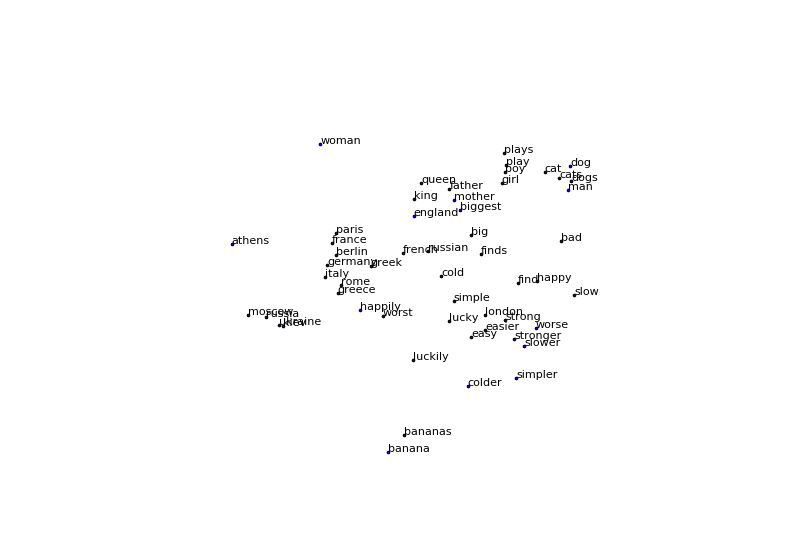

In [11]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import pylab
fig = pylab.figure(figsize=(10,7))
ax = Axes3D(fig)
to_tsne = open('to_tsne.txt', 'r')
for string in to_tsne:
    for word in string.split():
        added_words.index(word)
        x, y, z = low_dim_embs[added_words.index(word)]
        ax.scatter(x, y, z,c='b', s=5) 
        ax.text(x, y, z, word, size=10, zorder=1, color='k')
to_tsne.close()
fig.savefig('tsne')
ax.axis('off')
pylab.show()

Немного покрутив можно получить другую перспективу, но в этой:

Бананы оказались близки между собой; Украина, Киев, Москва и Россия получились в кластере; Европейские страны получились в кластере; близки king-queen, father-mother; близки dog-dogs, cat-cats.